In [2]:
from PIL import Image
import colorsys
import subprocess 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
from platform import python_version
print(python_version())

3.6.7


## Generación de prueba

In [3]:
def preparar_img(name):
    img = Image.open(os.path.join(image_path,name)).convert("L")
    width, height = img.size
    data = ""
    imgdata = list(img.getdata())
    for i in range(0,height):        
        indexes = range(i*width,i*width+width)
        data = data + " ".join([str(imgdata[x]) for x in indexes]) + "\n"
    input_text = "{0} {1}\n{2}".format(height,width,data)
    return (height, width, input_text, img)

## Experimento 1: Tiempo de ejecución según valor de K

In [4]:
image_path = "../datos_entrada/ej1/"

"""Elegir el archivo desde donde se obtendran los datos(1 o 2)
este archivo es donde escribe el programa de c++ en la funcion escribir_tiempo"""
#1-archivo default
#csvFileName="./ej1_tiempos.csv"
#2-archivo_sin outliers
csvFileName="./ej1_tiempos_sin_outliers.csv"

test_times = 10
images = {
        "test1.jpg": None,
        "test2.png": None
}
methods = [0,1,2]

kRange = range(500,6001,500)
for path in images:
    images[path] = preparar_img(path)  

In [5]:
for k in kRange:
    for m in methods:
        for imgName,imgData in images.items():
            completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
            if completado.returncode != 0:
                print("ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo))

In [6]:
csv = pandas.read_csv(csvFileName)


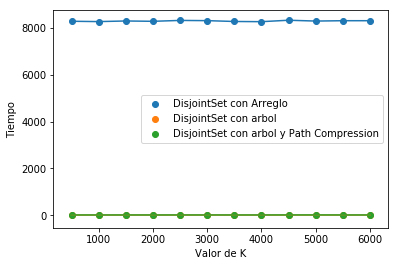

In [7]:
plt.clf()
for method in csv["Metodo"].unique():
    methodResults = csv.dropna(subset=['Filename'])
    methodResults = methodResults[methodResults["Metodo"] == method]
    resultsByK = [np.median(methodResults[methodResults["k"] == k]["Tiempo"]) for k in kRange]
    plt.scatter(kRange,resultsByK,label=method)
    plt.plot(kRange,resultsByK, linestyle='-')

plt.legend();
plt.xlabel("Valor de K")
plt.ylabel("Tiempo(mseg)");

plt.savefig('../graficos_ej1/exp_cuantitativos/exp1_k/k-3estructuras.png', dpi=100)

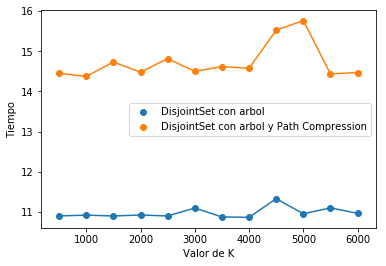

In [8]:
plt.clf()
for method in csv["Metodo"].unique():
    if method != "DisjointSet con Arreglo":
        csvOnlyNames = csv.dropna(subset=['Filename'])
        methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
        resultsByK = [np.median(methodResults[methodResults["k"] == k]["Tiempo"]) for k in kRange]
        plt.scatter(kRange,resultsByK,label=method)
        plt.plot(kRange,resultsByK, linestyle='-')

plt.legend();
plt.xlabel("Valor de K")
plt.ylabel("Tiempo(mseg)");

plt.savefig('../graficos_ej1/exp_cuantitativos/exp1_k/k-2estructuras.png', dpi=100)


### Corelación entre tiempo de ejecución y cota de algortimo para cada una de estructuras

In [30]:
#casos de interes son los que tiene nombre y un k que pertenezca al rango [500,6000]
nombres_a_ver = [
                "test_1_320x240.jpg", 
                "test_2_320x240.png",
                "sintetico_1_320x180.png",
                "sintetico_1_640x360.png",
                "sintetico_1_1280x720.png",
                "sintetico_1_1920x1080.png"
                ]
csv_cotas = pandas.DataFrame()
for k in kRange:
    csv_aux_name = csv.dropna(subset=['Filename'])
    csv_aux_k = csv_aux_name[csv_aux_name["k"] == k]
    csv_cotas = pandas.concat([csv_cotas, csv_aux_k])
#todos los nombres tienen el mismo formato "nombre_num_anchoxalto.extension"
csv_cotas.loc[csv_cotas['Filename'] == 'test1.jpg', 'Filename'] = 'test_1_320x240.jpg'
csv_cotas.loc[csv_cotas['Filename'] == 'test2.png', 'Filename'] = 'test_2_320x240.png'
csv_cotas = csv_cotas[csv_cotas['Filename'].isin(nombres_a_ver)]
#armar columna n, donde n es la cant de pixeles cada imagen
split_guion_csv = pandas.DataFrame()
split_guion_csv[['nombre', 'num', 'anchoxalto']] = csv_cotas['Filename'].str.split('_', expand=True)
split_x_csv = pandas.DataFrame()
split_x_csv[['ancho', 'alto']] = split_guion_csv['anchoxalto'].str.split('x', expand=True)
split_x_csv['ancho'] = pandas.to_numeric(split_x_csv['ancho'])
split_x_csv['alto'] = split_x_csv['alto'].str.rstrip('.png')
split_x_csv['alto'] = split_x_csv['alto'].str.rstrip('.jpg')
split_x_csv['alto'] = pandas.to_numeric(split_x_csv['alto'])
csv_cotas["n"] = split_x_csv['ancho'] * split_x_csv['alto']
#separo por metodos y por cada uno armo la columna cota 
csv_cotas_arr = csv_cotas[csv_cotas['Metodo'] == 'DisjointSet con Arreglo']
csv_cotas_arb = csv_cotas[csv_cotas['Metodo'] == 'DisjointSet con arbol']
csv_cotas_arbYpath = csv_cotas[csv_cotas['Metodo'] == 'DisjointSet con arbol y Path Compression']
csv_cotas_arr.loc[:,"cota"] = csv_cotas_arr["n"] * csv_cotas_arr["n"]
csv_cotas_arb.loc[:,"cota"] = csv_cotas_arb["n"] * np.log(csv_cotas_arb["n"])
csv_cotas_arbYpath.loc[:,"cota"] = csv_cotas_arbYpath["n"]*2 #* np.log(csv_cotas_arbYpath["n"])

<Figure size 432x288 with 0 Axes>

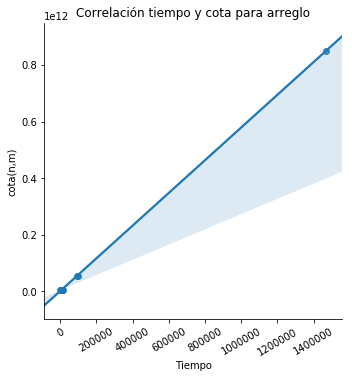

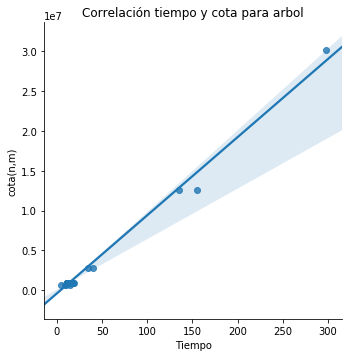

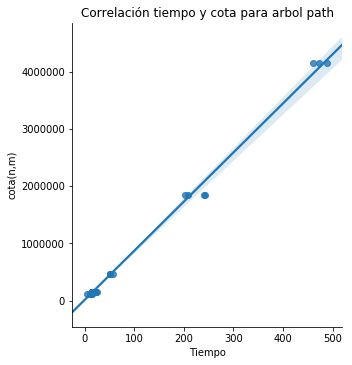

In [31]:
plt.clf()
# # Grafico correlación.
ax1 = sns.lmplot(x='Tiempo', y='cota', data=csv_cotas_arr);
ax1.set_xticklabels(rotation=30)
plt.title('Correlación tiempo y cota para arreglo')
plt.xlabel("Tiempo");
plt.ylabel("cota(n,m)");

plt.savefig('../graficos_ej1/exp_cuantitativos/exp1_k/correlacion-arreglo.png', dpi=100)

ax2 = sns.lmplot(x='Tiempo', y='cota', data=csv_cotas_arb);
plt.title('Correlación tiempo y cota para arbol')
plt.xlabel("Tiempo");
plt.ylabel("cota(n,m)");

plt.savefig('../graficos_ej1/exp_cuantitativos/exp1_k/correlacion-arbol.png', dpi=100)

ax3 = sns.lmplot(x='Tiempo', y='cota', data=csv_cotas_arbYpath);
plt.title('Correlación tiempo y cota para arbol path')
plt.xlabel("Tiempo");
plt.ylabel("cota(n,m)");

plt.savefig('../graficos_ej1/exp_cuantitativos/exp1_k/correlacion-arbol-Path.png', dpi=100)

fig = plt.gcf()

In [32]:
c_arr = np.corrcoef(csv_cotas_arr["Tiempo"], csv_cotas_arr["cota"])[0, 1];
print("El coeficiente de correlación de Pearson para arreglo es: c_arr="+str(c_arr))
c_arb = np.corrcoef(csv_cotas_arb["Tiempo"], csv_cotas_arb["cota"])[0, 1];
print("El coeficiente de correlación de Pearson para arbol es: c_arb="+str(c_arb))
c_arbYpath = np.corrcoef(csv_cotas_arbYpath["Tiempo"], csv_cotas_arbYpath["cota"])[0, 1];
print("El coeficiente de correlación de Pearson para arbol con path compresion es: arbYpath="+str(c_arbYpath))

El coeficiente de correlación de Pearson para arreglo es: c_arr=0.9999664078168559
El coeficiente de correlación de Pearson para arbol es: c_arb=0.9956721578466106
El coeficiente de correlación de Pearson para arbol con path compresion es: arbYpath=0.9981480589445603


## Experimento 2: Tiempo de ejecución según tamaño de la imagen

### Considerando DisjointSet con Arreglo

In [3]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
images = {
        "sintetico_1_320x180.png": None,
}
methods = [0,1,2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [4]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print("ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo))

In [4]:
csv = pandas.read_csv(csvFileName)

DisjointSet con Arreglo [5364.725]
DisjointSet con arbol [9.63416]
DisjointSet con arbol y Path Compression [11.973849999999999]


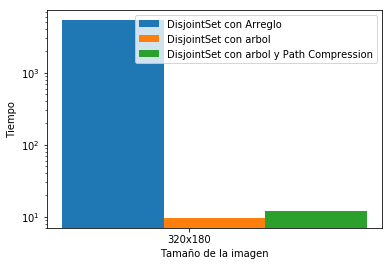

In [5]:
plt.clf()

metodos = csv["Metodo"].unique()
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo(mseg)");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180"][:len(images.keys())])
plt.yscale('log')

plt.savefig('../graficos_ej1/exp_cuantitativos/exp2_tiempoEjecucion/tiempo-imgMasChica.png', dpi=100)

Incluso en el caso de la imagen más chica(320x180) el metodo con DisjointSet con Arreglo tarda varios ordenes de magnitud más que los otros dos casos, por lo que de ahora en adelante vamos a descartarlo por ser demasiado lento.

### Sin considerar DisjointSet con Arreglo

In [3]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        "sintetico_1_640x360.png": None,
        "sintetico_1_1280x720.png": None,
        "sintetico_1_1920x1080.png": None,
}
methods = [1, 2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [99]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

In [4]:
csv = pandas.read_csv(csvFileName)

DisjointSet con arbol [9.63416, 37.332499999999996, 145.326, 297.644]
DisjointSet con arbol y Path Compression [11.973849999999999, 51.11945, 224.74450000000002, 468.841]


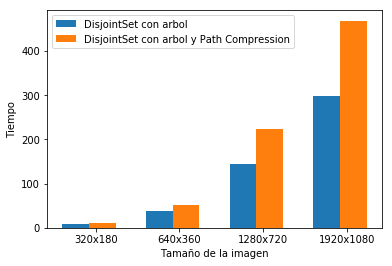

In [5]:
plt.clf()

metodos = [i for i in csv["Metodo"].unique() if i != "DisjointSet con Arreglo"]
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo(mseg)");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180", "640x360", "1280x720", "1920x1080"][:len(images.keys())])

plt.savefig('../graficos_ej1/exp_cuantitativos/exp2_tiempoEjecucion/tiempo-todasImgs.png', dpi=100)